In [0]:
# model.model.save('words_input30_batch128.h5')


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
print("GPU:", tf.test.gpu_device_name())
import numpy as np

TensorFlow 2.x selected.
Tensorflow version: 2.0.0
GPU: /device:GPU:0


In [3]:
!git clone https://github.com/michalovsky/books-data.git

Cloning into 'books-data'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 79 (delta 20), reused 57 (delta 13), pack-reused 0
Unpacking objects: 100% (79/79), done.


In [4]:
import glob

def read_data(directory):
  file_paths = glob.glob(directory +"*.txt")    
  text = ""
  for file_path in file_paths:
    with open(file_path, 'r', encoding="utf-8-sig") as file:
      file_content = file.read()
      text+=file_content
  return text

directory1 = "books-data/kafka/"
directory2 = "books-data/shelley/"
directory3 = "books-data/defoe/"
directory4 = "books-data/plato/"

text = read_data(directory3)
print ('Length of text: {} characters'.format(len(text)))

Length of text: 621863 characters


In [5]:
import string

class DataProcessor:
	def __init__(self, chars_to_remove, chars_to_translate, replacement_chars):
		self.chars_to_remove = chars_to_remove
		self.chars_to_translate = chars_to_translate
		self.replacement_chars = replacement_chars

	def preprocess_data(self, text):
		removal_translator = str.maketrans("", "", self.chars_to_remove)
		special_characters_translator = str.maketrans(self.chars_to_translate, self.replacement_chars , '')
		text = text.lower().translate(removal_translator).translate(special_characters_translator)
		text = "".join( list( map(DataProcessor.__split_punctuation_from_sentence , text)))
		text = " ".join(text.split())
		return text
	
	@staticmethod
	def __split_punctuation_from_sentence(char):
		if (char == '.' or char == ','):
		  return (" " + char + " ")
		else:
			return (char)

characters_to_remove = '–—”„…«»‘’“°ſ†•✠' + '!\"#$%&\'()*+-/:;<=>?@[\]^_`{|}~' + string.digits  
characters_to_translate = 'ąćęłńóśźżäöüæèêéôâáà£çëîñòùúûāœï'
replacement_characters = 'acelnoszzaoueeeeoaaaeceinouuuaei'

dataprocessor = DataProcessor(characters_to_remove, characters_to_translate, replacement_characters)
text = dataprocessor.preprocess_data(text)

unique_characters = sorted(list(set(text)))
print ('{} unique characters:'.format(len(unique_characters)))
print(unique_characters)

words = text.split()
print('Total words:', len(words))

vocab = sorted(set(words))
vocab_size = len(vocab)
print('Unique words:', vocab_size)

29 unique characters:
[' ', ',', '.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Total words: 134362
Unique words: 6359


In [6]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from random import randint

word_to_indices = dict((w, i) for i, w in enumerate(vocab))
indices_to_word = dict((i, w) for i, w in enumerate(vocab))

class Dataset:
	def __init__(self):
		self.text_sequences = list()
		self.X_train = list()
		self.y_train = list()
		self.X_val = list()
		self.y_val = list()

	def make_dataset(self, words, input_sequence_length=10, output_sequence_length=1):
		sequence_length = input_sequence_length + output_sequence_length 
		tokens = self.__create_tokens(words, sequence_length)
		self.__create_training_and_validation_set(tokens)
		return self

	def __create_tokens(self, words, sequence_length):
		encoded_words = [word_to_indices[word] for word in words]
		tokens = list()
		for i in range(sequence_length, len(words)):
			line = ' '.join(words[i-sequence_length:i])
			self.text_sequences.append(line)
			tokens.append(encoded_words[i-sequence_length:i])
		return tokens

	def __create_training_and_validation_set(self, tokens):
		data = np.asarray(tokens)
		X, y = data[:,:-1], data[:,-1]
		y = np_utils.to_categorical(y, num_classes=vocab_size)
		self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X, y, test_size=0.2, shuffle=True)

	def get_random_sequence(self):
		return self.text_sequences[randint(0, len(self.text_sequences))]
    
input_sequence_length = 30
output_sequence_length = 1
dataset = Dataset().make_dataset(words, input_sequence_length, output_sequence_length)

print('Total Sequences:',  len(dataset.text_sequences))

Using TensorFlow backend.


Total Sequences: 134331


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Embedding
from tensorflow.keras.constraints import max_norm

class Model:
  def __init__(self):
    self.model = Sequential()
    self.__build_model()
    self.__compile_model()
    self.model.summary()

  def __build_model(self):
    self.model.add(Embedding(vocab_size, 50, input_length=input_sequence_length))
    self.model.add(LSTM(100, return_sequences=True, recurrent_initializer='glorot_uniform', kernel_constraint=max_norm(3)))
    self.model.add(BatchNormalization())
    self.model.add(LSTM(100, recurrent_initializer='glorot_uniform', kernel_constraint=max_norm(3)))
    self.model.add(BatchNormalization())
    self.model.add(Dense(vocab_size, activation='softmax'))

  def __compile_model(self):
    self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  def fit_model(self, X_train, y_train, validation_data, epochs, batch_size, callbacks):
    return self.model.fit(
        X_train,
        y_train,
        validation_data=validation_data,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        callbacks=callbacks
    )

model = Model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 50)            317950    
_________________________________________________________________
lstm (LSTM)                  (None, 30, 100)           60400     
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 100)           400       
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense (Dense)                (None, 6359)              642259    
Total params: 1,101,809
Trainable params: 1,101,409
Non-trainable params: 400
____________________________________________

In [0]:
from keras.preprocessing.sequence import pad_sequences

def generate_text(model, seed, words_amount):
	result = list()
	input_text = seed
	for _ in range(words_amount):
		encoded_text = [word_to_indices[word] for word in input_text.split()]
		encoded_text = pad_sequences([encoded_text], maxlen=input_sequence_length, truncating='pre')
		predictions = model.predict_classes(encoded_text, verbose=0)
		predicted_word = indices_to_word[predictions[0]]
		input_text += ' ' + predicted_word
		result.append(predicted_word)
	result = ' '.join(result).replace(" ,", ",").replace(" .", ".\n")
	return result

In [9]:
from tensorflow.keras.callbacks import EarlyStopping as EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, Callback

seed_for_epochs = dataset.get_random_sequence()
print("Checking with seed:", seed_for_epochs)

def on_epoch_end(epoch, _):
    print()
    print('Generated text:')
    print(generate_text(model.model, seed=seed_for_epochs, words_amount=50))
    print()
    
text_generation = LambdaCallback(on_epoch_end=on_epoch_end)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=50)

Checking with seed: all on a sudden covered over with foam and froth the shore was covered with the breach of the water , the trees were torn up by the roots , and


In [10]:
batch_size = 128
epochs = 100
callbacks = [early_stopping, text_generation]
history = model.fit_model(dataset.X_train, dataset.y_train, validation_data=(dataset.X_val, dataset.y_val), epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Train on 107464 samples, validate on 26867 samples
Epoch 1/100

Generated text:
the other of the sea were, and the other of the sea, and the other of the sea were, and the other of the sea, and the other of the sea were, and the other of the sea, and the other of the sea

107464/107464 - 25s - loss: 5.6757 - accuracy: 0.1525 - val_loss: 5.0072 - val_accuracy: 0.1777
Epoch 2/100

Generated text:
the other part of the island, i had been been to be driven into my mind, or the island, i had been able to be sure, i had been not be able to be sure, i had been been to be done, i had

107464/107464 - 16s - loss: 4.6368 - accuracy: 0.1982 - val_loss: 4.9740 - val_accuracy: 0.1717
Epoch 3/100

Generated text:
the captain began to enter me a great deal of a good pouch, and began to enter a great deal of a small piece of ground, and began to enter a great deal of a small piece of ground, and began to enter a great deal of

107464/107464 - 17s - loss: 4.2739 - accuracy: 0.2210 - val_loss: 4.8407 - 

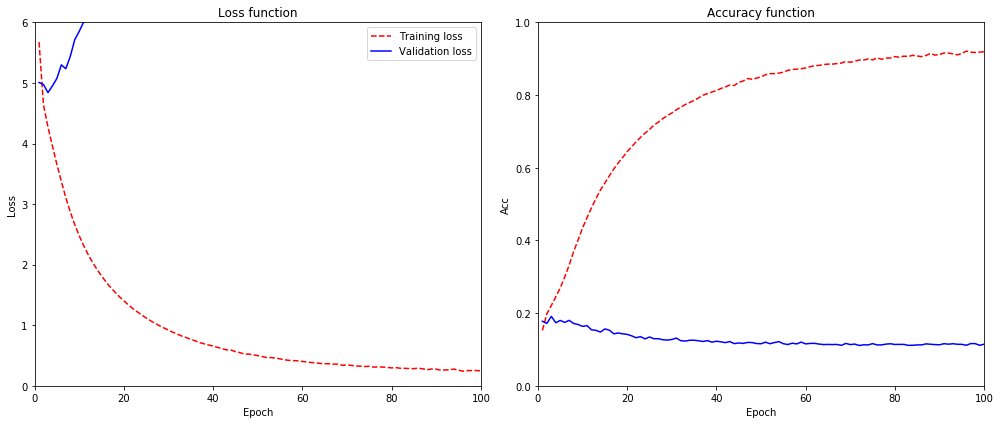

In [15]:
import matplotlib.pyplot as plt

# Make characteristics
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

f = plt.figure(figsize=(14,6))

a0 = f.add_subplot(121)
a0.plot(epoch_count, training_loss, 'r--', label="Training loss")
a0.plot(epoch_count, validation_loss, 'b-', label="Validation loss")
a0.legend()
a0.set_title("Loss function")
a0.set_xlabel("Epoch")
plt.xlim(0, epochs)
a0.set_ylabel("Loss")
plt.ylim(0, np.ceil(max(training_loss)))

a1 = f.add_subplot(122)
a1.plot(epoch_count, training_acc, 'r--', label="Training acc")
a1.plot(epoch_count, validation_acc, 'b-', label="Validation acc")
a1.set_title("Accuracy function")
a1.set_xlabel("Epoch")
plt.xlim(0, epochs)
a1.set_ylabel("Acc")
plt.ylim(0, 1)

plt.savefig('words_input30_batch128.png')

plt.tight_layout()
plt.show()

In [20]:
seed = dataset.get_random_sequence()
print("Generating with seed:",seed, "\n")
generated_text = generate_text(model.model, seed, words_amount=300)
print(generated_text)

Generating with seed: . i observed that the three other men had liberty to go also where they pleased but they sat down all three upon the ground , very pensive , and looked 

like howlings and break directly up to the place so close to the creek very taking by the horror of the negroes but i could not stir, by any more of the savages, who was in the middle of the longboat of his justice of god had delivered me that many things.
 the man come, i was the most dexterous fellow at managing, at a word, and then catch them.
 upon this affair by my last means to this piece of my story, and three fowlingpieces of the fowlingpiece, with friday, tying one out with the stock for a row of long two men might ironwork enough, and gave their orders and that men hanged them.
 this appeared not.
 but with these thoughts i had been comforted with a mark, that i was about three leagues from the place, and i believe no more nor friends, yet so i never could really worked undertaken my boat but at that i 